In [64]:
import csv
import pandas as pd
import numpy as np
import sklearn
from sklearn.cluster import KMeans
import pickle
import matplotlib.pyplot as plt
import matplotlib.ticker as MT
import matplotlib.lines as L
import matplotlib.cm as CM
import matplotlib.colors as C
import matplotlib.patches as PA
import matplotlib
import matplotlib.patches as mpatches
from tol_colors import tol_cmap
import glob
from matplotlib import cm
plt.close('all')
plt.style.use('default')
plt.rc('font', family='serif')

plt.rcParams.update({'font.size': 14})
shape_points = {
    3:[[0, 0.5, 1.0, 0],[0, np.sqrt(3) / 2, 0, 0],(0.5, 1.0 / (2 * np.sqrt(3)))],
    4:[[0, 0., 1.0, 1.,0],[0,1., 1., 0, 0], (0.5, 0.5)],
    5:[[0, -0.31,0.5, 1.31, 1.,0],[0,0.95,1.54, 0.95, 0, 0], (0.5, 0.688)]
}
def plotSimplex(points, fig=None, 
                vertexlabels=['1','2','3'],
                sizes=None,
                **kwargs):
    """
    Plot Nx3 points array on the 3-simplex 
    (with optionally labeled vertices) 
    
    kwargs will be passed along directly to matplotlib.pyplot.scatter    
    Returns Figure, caller must .show()
    """
    dimension = points.shape[1]
    if(fig == None):        
        fig = plt.figure(figsize=(3, 3))
    # Draw the triangle
    xs = shape_points[dimension][0]
    ys = shape_points[dimension][1]
    
    l1 = L.Line2D(xs, # xcoords[0, 0.5, 1.0, 0]
                  ys, # ycoords[0, np.sqrt(3) / 2, 0, 0]
                  color='gray', linewidth=1)
    
    fig.gca().add_line(l1)
    fig.gca().xaxis.set_major_locator(MT.NullLocator())
    fig.gca().yaxis.set_major_locator(MT.NullLocator())
    plt.axis('off')
    # Draw vertex labels
    for i in range(dimension):
        x_direction = -1 if xs[i] > 0.5 else -1
        y_direction = 1 if ys[i] > 0.5 else -1
        fig.gca().text(xs[i] + x_direction *0.45 ,ys[i] + y_direction * 0.15, vertexlabels[i])
    # Project and draw the actual points
    base_size = 75
    projected = projectSimplex(points)
    max_size = 2
    if sizes is None:
        plt.scatter(projected[:,0], projected[:,1],**kwargs) 
    else:
        for i in range(points.shape[0]):    
            plt.scatter(projected[i,0], projected[i,1], s=base_size*sizes[i], c=kwargs['c'][i])
            
    # Leave some buffer around the triangle for vertex labels
    fig.gca().set_xlim(-0.2 + min(xs), 0.2 + max(xs))
    fig.gca().set_ylim(-0.2 + min(ys), 0.2 + max(ys))

    return fig    

def projectSimplex(points):
    """ 
    Project probabilities on the 3-simplex to a 2D triangle
    
    N points are given as N x 3 array
    """
    # Convert points one at a time
    dimension = points.shape[1]
    centroid = shape_points[dimension][2]
    xs = shape_points[dimension][0]
    ys = shape_points[dimension][1]
    tripts = np.zeros((points.shape[0],2))
    for idx in range(points.shape[0]):
        # Init to triangle centroid
        x = centroid[0] # 1.0 / 2
        y = centroid[1] # 1.0 / (2 * np.sqrt(3))
        for i in range(dimension):
            weight = points[idx, i]
            x += (weight * xs[i] + (1-weight) * centroid[0]) - centroid[0]
            y += (weight * ys[i] + (1-weight) * centroid[1]) - centroid[1]
        tripts[idx,:] = (x,y)
    return tripts
start = 0.0
stop = 1.0
number_of_lines= 10
cm_subsection = np.linspace(start, stop, number_of_lines) 
colors = [ cm.hsv(x) for x in cm_subsection ]
cmap = tol_cmap('rainbow_discrete', 10)
colors = cmap(1.0)
colors = [ cmap(x) for x in cm_subsection ]
base_dir = '../logs/highway/'
LEGEND_FONT_SIZE = 28
AXIS_FONT_SIZE = 28
TICKS_FONT_SIZE = 26
MARKER_SIZE = 10
LINE_WIDTH = 3.0
TITLE_SIZE= 32

In [66]:
def plot_for_paper(dir_path, num_clusterings = 6, feat_index=0):
    """ 
    Plot the simplexes and the IRL and clustering loss as function of the number of clusters
    
    Assumes the clustering was made using:
    """
    paths = glob.glob(dir_path)
    data = [i for i in range(num_clusterings)]
    for p in paths:
        results = pickle.load(open(p,'rb'))
        num_clusters = results['weights'].shape[0]
        data[num_clusters-2] = results
    losses = []
    cluster_sizes = []
    for i,results in enumerate(data):
        if isinstance(results, int):
            data.pop(i)
    
    for results in data:
        if isinstance(results, int):
            continue
        points = results['weights']
        losses.append(results['loss'])
        cluster_sizes.append(points.shape[0])
        fig = plotSimplex(points, s=100, vertexlabels=results['features'], c=colors[:len(points)],
                         sizes=np.sum(results['assignment'], axis=1))
        out_dir = base_dir + 'clustering/' + str(points.shape[0]) + '_clusters.pdf'
        fig.savefig(out_dir, bbox_inches='tight')
    feat_index = points.shape[-1] - 3 
    X = feature_expectations[:,features_idx]
    wcss = []
    for i in range(2, num_clusterings+2):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(X)
        wcss.append(kmeans.inertia_)
        
    fig, ax1 = plt.subplots()

    ax2 = ax1.twinx()
    ax1.plot(cluster_sizes, losses,'g-', marker='o')
    ax2.plot(range(2, num_clusterings+2), wcss, 'b-', marker='o')
    ax1.set_xlabel('Number of clusters')
    ax1.set_ylabel('IRL Loss', color='g')
    ax2.set_ylabel('WCSS', color='b')
    plt.title('Elbow Method')
    plt.show()
    out_dir = base_dir + 'clustering/' + 'clustering_loss.pdf'
    fig.savefig(out_dir, bbox_inches='tight')
    return data

# Load precomputed feature expectations and run fe clustering
## Prerequisites: 
### Execute utils/trajectories_reader.py to read the raw data of the trajectories and create the state, action, reward representation used for IRL
### Execute run_evaluation_highway.py which read the processed trajectories and generates the feature expectations

In [67]:
feature_expectations =  np.array(pickle.load(open( base_dir + 'feature_expectations','rb')))
agents = np.array(['Bob', 'Alice', 'Carol', 'Chuck', 'Craig', 'Dan', 'Erin', 'Eve', 'Grace', 'Judy'])
agent_features_expectations = {}
feature_labels = np.array([ 'free_right', 'lane_change', 'distance_front'])
features_idx = [0,1,2]
num_agents=10

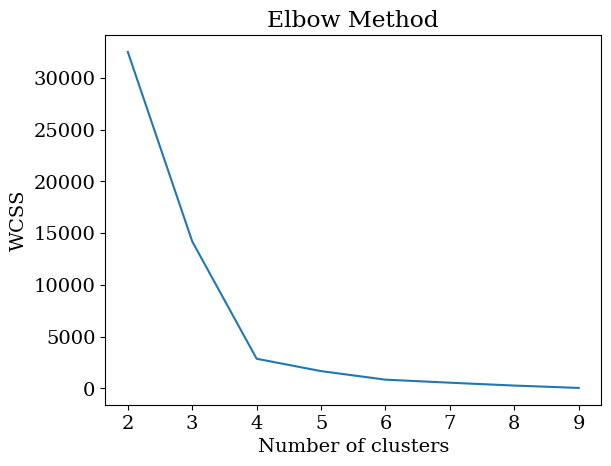

In [68]:
X = feature_expectations[:num_agents,features_idx]
wcss = []
for i in range(2, 10):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
    
plt.plot(range(2, 10), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [69]:
num_agents = 10
num_clusters = 4
for features in [features_idx]:
    X = feature_expectations[:num_agents,features]
    kmeans = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    print("Agents:")
    print(agents[:num_agents])
    print("Features:")
    print(feature_labels[features])
    print("Assignment")
    print(kmeans.labels_)
    print()

Agents:
['Bob' 'Alice' 'Carol' 'Chuck' 'Craig' 'Dan' 'Erin' 'Eve' 'Grace' 'Judy']
Features:
['free_right' 'lane_change' 'distance_front']
Assignment
[3 3 2 0 1 3 2 3 3 1]



# Compare IRL and FE clustering
# Draw weights of clusters in the simplex (Figure 10)
# Draw IRL and BC loss as function of number of clusters (Figure 9)
## Prerequisites:
### Execute Run_highway_irl.py for each agent to perform BC and compute the gradients
### Execute Run_clustering_highway.py for each number of cluster (2-7) to save the clustering results
### To execute the clustering for all number of clusters from 2-7 run perform_clusterings_highway.sh

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

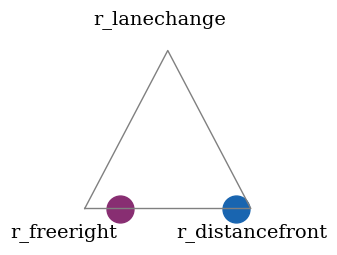

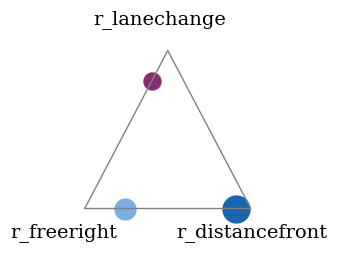

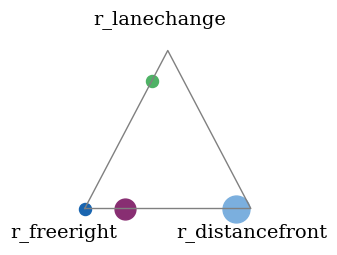

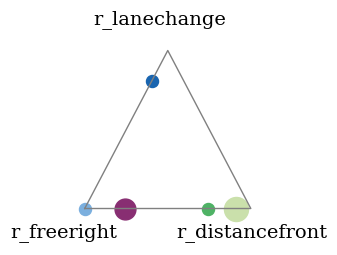

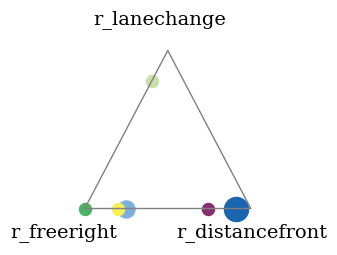

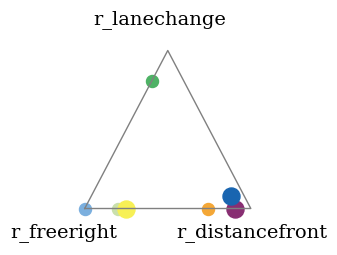

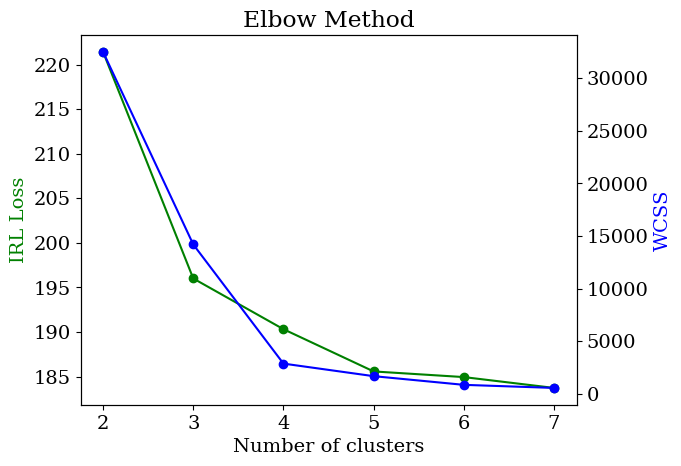

In [95]:
dir_path = base_dir + 'clustering/results_*'
data = plot_for_paper(dir_path)

# Plot the Accuracy of BC policies (Figure 8)
## Prerequisites: 
### Execute run_highway_irl.py to perform the BC 
### Execute run_evaluation_highway.py to compute the accuracies

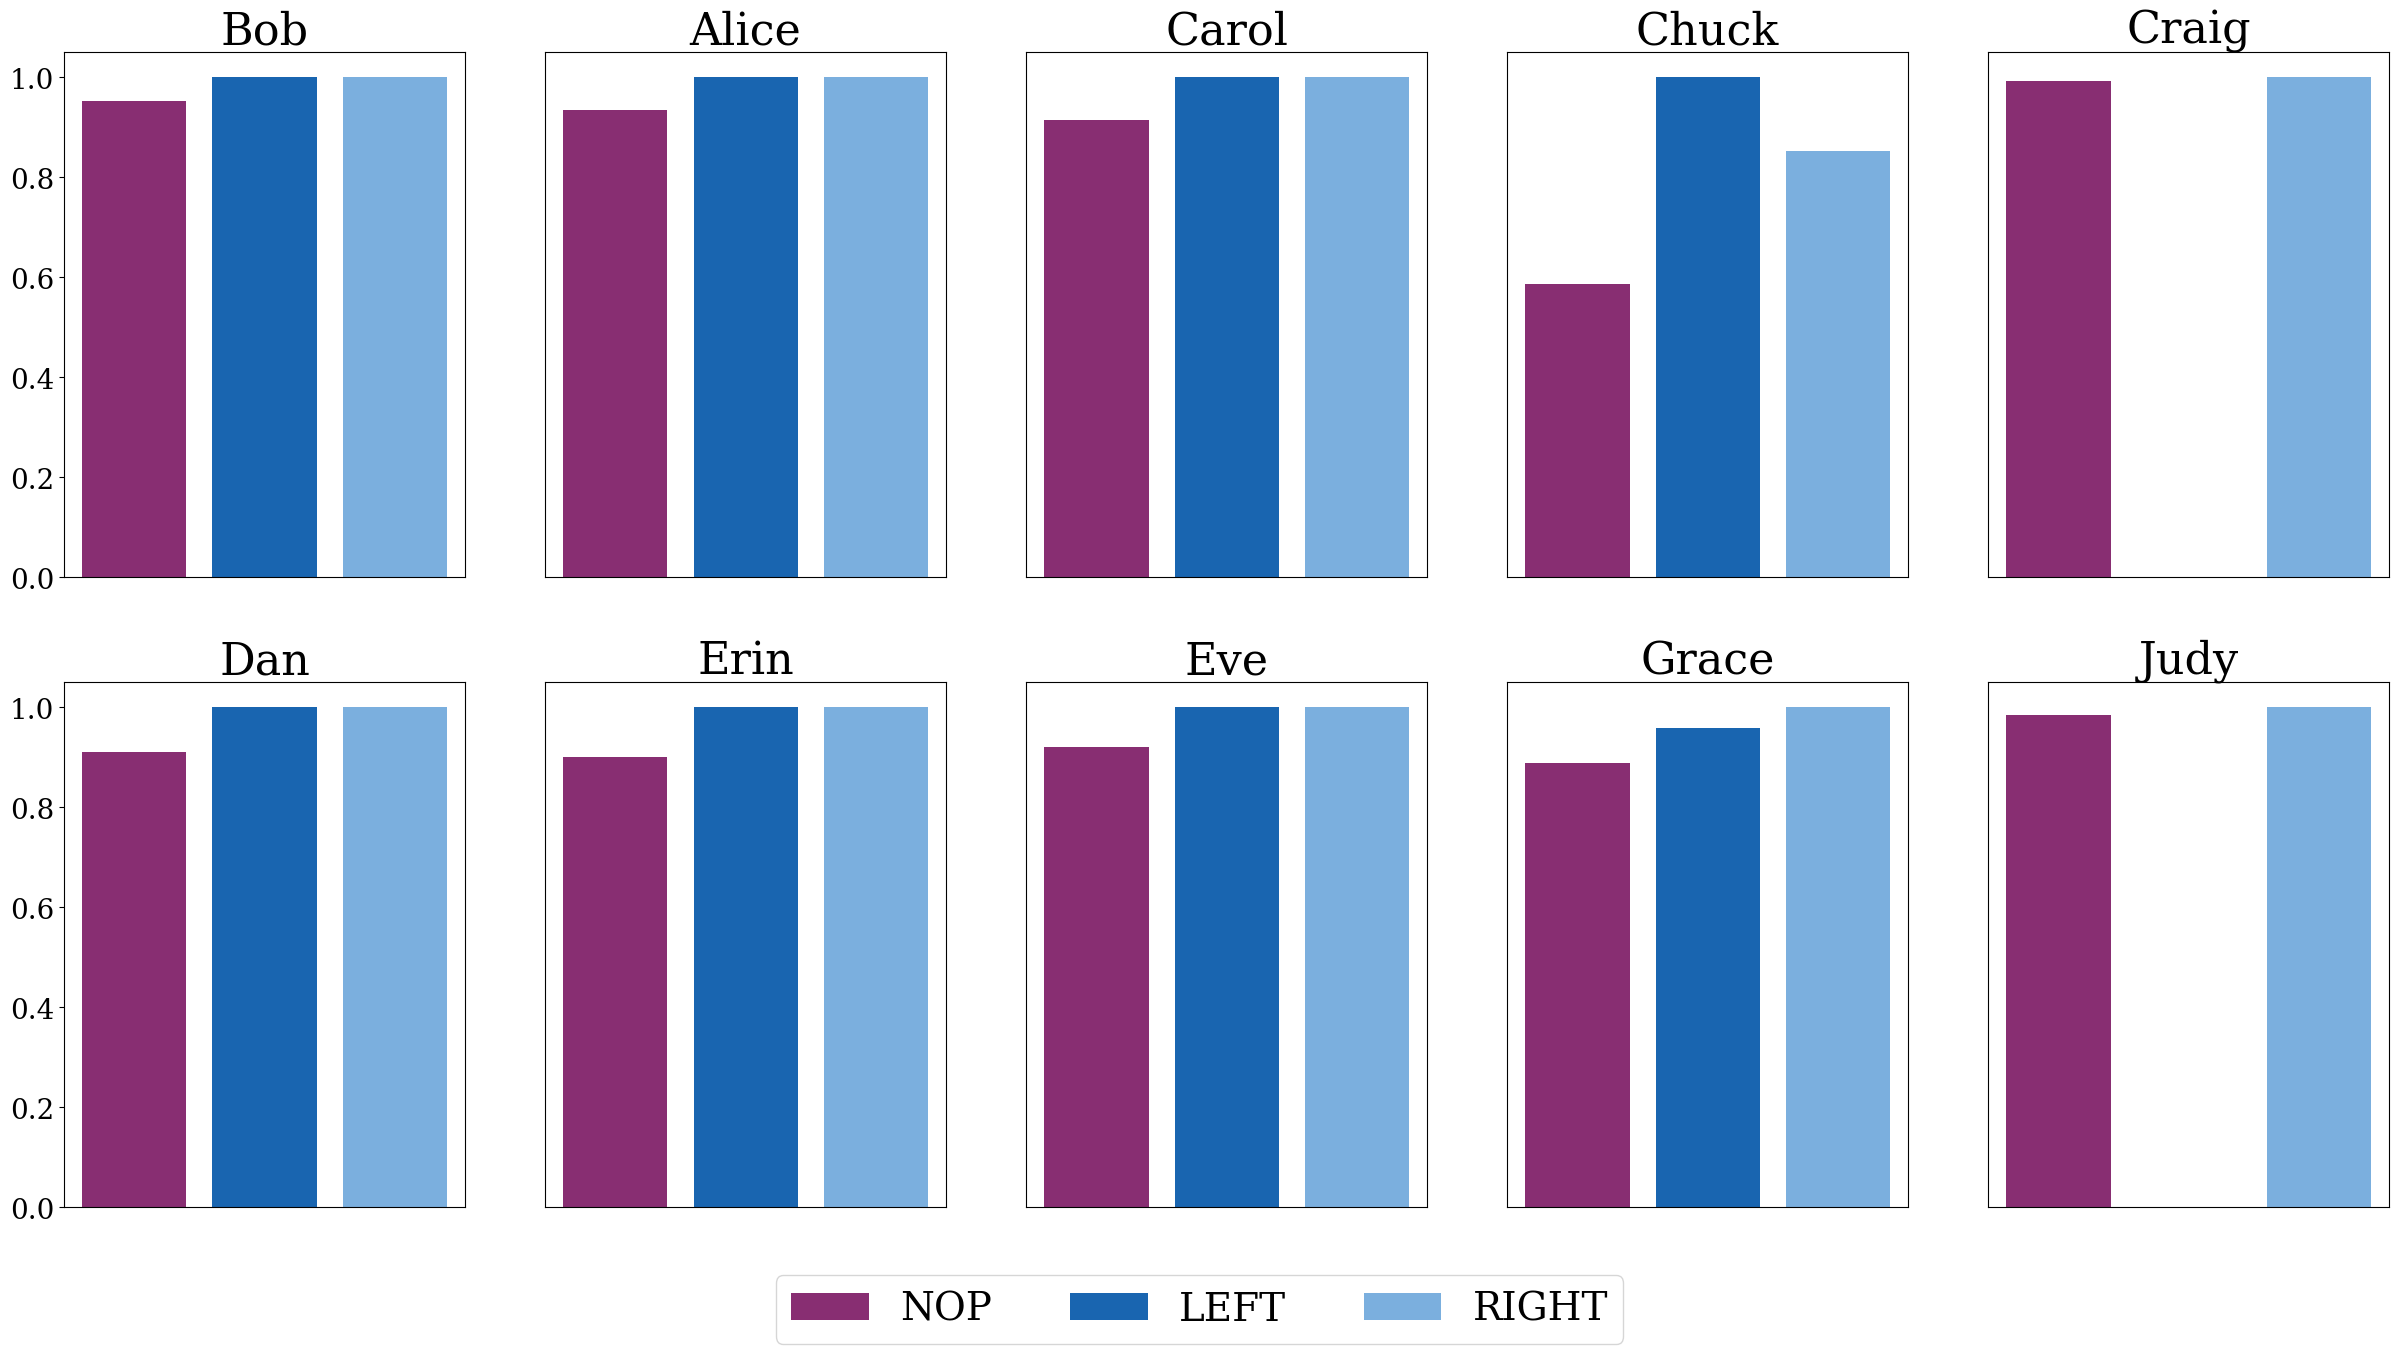

In [96]:

evaluations = pickle.load(open(base_dir + 'evaluations','rb'))
labels = ['NOP', 'LEFT', 'RIGHT']
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(30,15))
for i, agent in enumerate(agents):
    row = i // 5
    col = i % 5 
    evals = evaluations[agent][0]
    values = np.clip(evals,0,1)
    for j, v in enumerate(values):
        if i == 0:
            label = labels[j]
        else:
            label = None
        ax[row,col].bar(j, v,  color=colors[j], label=label)
    if  i % 5 == 0:
        ax[row,col].tick_params(labelsize=TICKS_FONT_SIZE)
    else:
        ax[row,col].set_yticks([])
    ax[row,col].set_title(agent,fontdict={'fontsize':TITLE_SIZE})
    ax[row,col].set_xticks([])
lgd = fig.legend(loc='lower center', ncol = 3, fontsize=LEGEND_FONT_SIZE)
fig.savefig(base_dir + 'bc.pdf',format='pdf',bbox_extra_artists=(lgd,), bbox_inches='tight',)

# Print the cluster assignment and respective weights with 4 clusters with Sigma-GIRL (Table 1 and 2)
## Prerequisite: 
###  Execute Run_clustering_highway.py with number of clusters equal to 4 to save the clustering results

In [98]:
num_clusters = 4
clustering_data = data[num_clusters -2]
clustering_agents = np.array(clustering_data['agents'])
print("Features:")
print(clustering_data['features'])
print("Assignment")
#print(clustering_data['assignment'])
assignment = clustering_data['assignment']
for i in range(assignment.shape[0]):
    indices = np.nonzero(assignment[i])[0]
    print([ agent_to_label[a] for a in clustering_agents[indices]])
    #print([ a for a in clustering_agents[indices]])
print("Weights")
print(clustering_data['weights'])

Features:
['r_freeright' 'r_lanechange' 'r_distancefront']
Assignment
['Eve', 'Grace', 'Alice']
['Craig']
['Carol', 'Erin', 'Bob', 'Dan', 'Chuck']
['Judy']
Weights
[[7.58126405e-01 0.00000000e+00 2.41873595e-01]
 [1.00000000e+00 0.00000000e+00 1.66977543e-13]
 [9.11526390e-02 0.00000000e+00 9.08847362e-01]
 [1.89730769e-01 8.07928400e-01 2.34083059e-03]]


# Perform the clustering on FE with 4 clusters (Table 3)


In [87]:
num_agents = 10
num_clusters = 4
for features in [features_idx]:
    X = feature_expectations[:num_agents,features]
    kmeans = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    print("Features:")
    print(feature_labels[features])
    print("Assignment")
    assignment = kmeans.labels_
    for i in range(num_clusters):
        indices = assignment == i
        print([ a for a in agents[indices]])
    print("Centroids")
    print(kmeans.cluster_centers_)

Features:
['free_right' 'lane_change' 'distance_front']
Assignment
['Chuck']
['Craig', 'Judy']
['Carol', 'Erin']
['Bob', 'Alice', 'Dan', 'Eve', 'Grace']
Centroids
[[-119.66621309 -143.09193874  -28.02532308]
 [ -10.15107479  -37.33946741 -112.44476304]
 [-253.86442461  -15.07282193   -5.83058693]
 [ -27.16062332  -73.13714683  -16.12711008]]


# Plot the feature expectations of each agent (Figure 6)

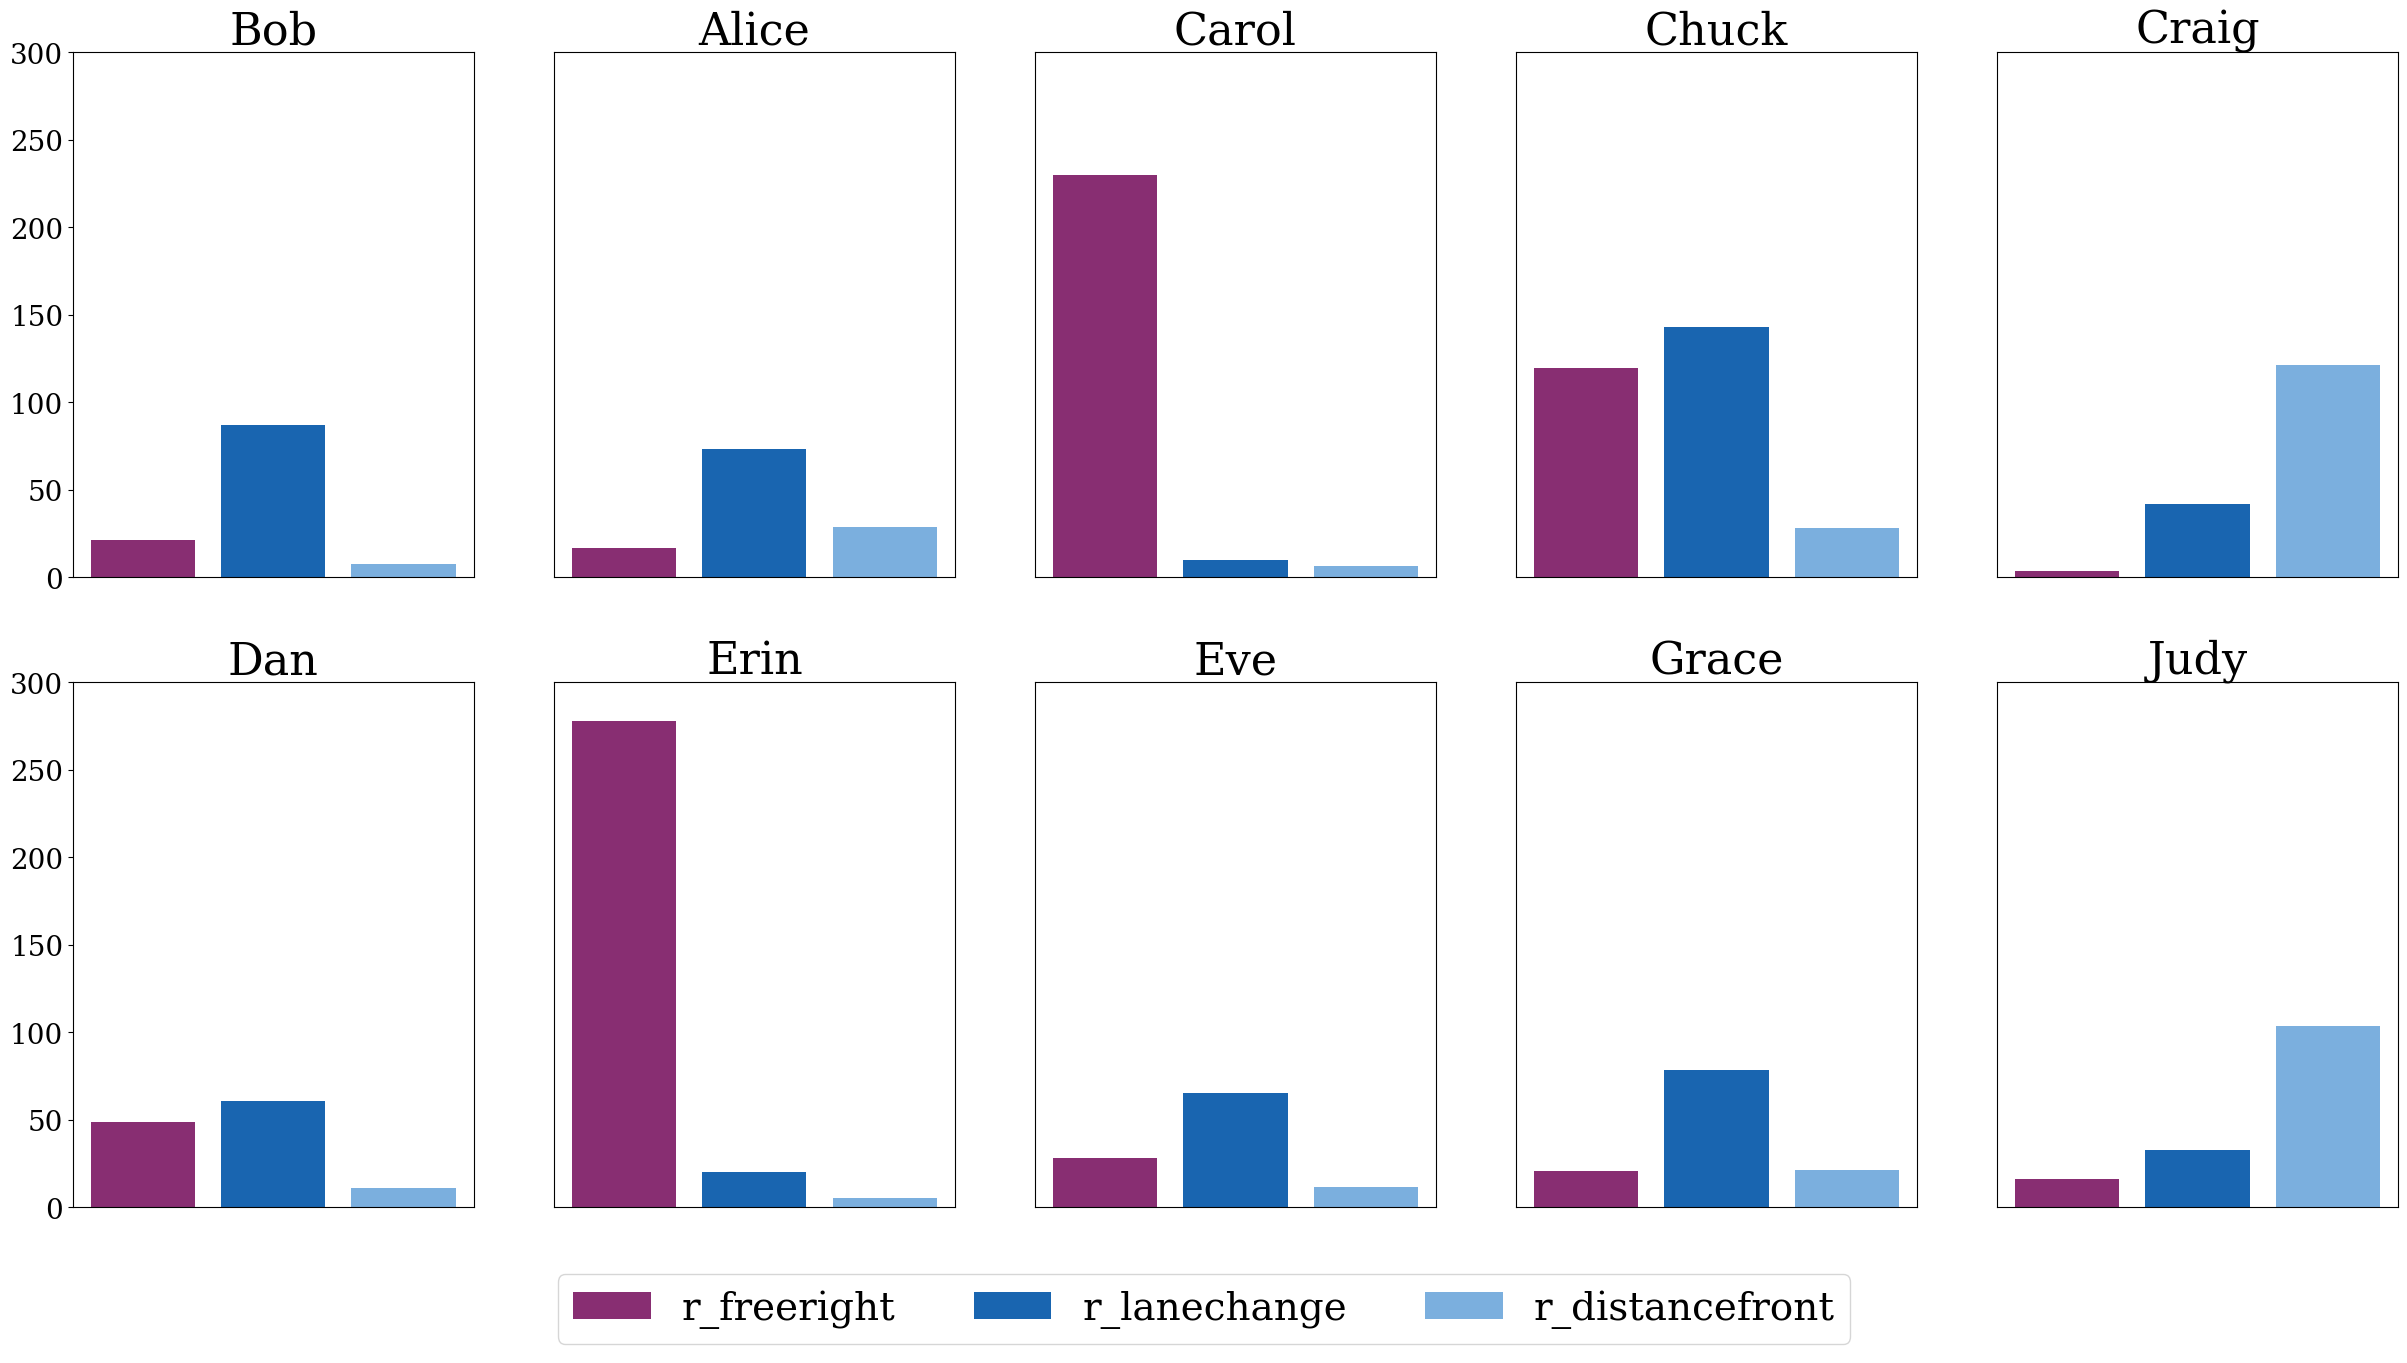

In [88]:
ticks_font_size = 20
evaluations = - feature_expectations[:num_agents,features_idx]
labels = ['r_freeright', 'r_lanechange', 'r_distancefront']
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(30,15))
for i, agent in enumerate(agents):
    row = i // 5
    col = i % 5 
    evals = evaluations[i]
    values = evals
    for j, v in enumerate(values):
        if i == 0:
            label = labels[j]
        else:
            label = None
        ax[row,col].bar(j, v,  color=colors[j], label=label)
    if  i % 5 == 0:
        ax[row,col].tick_params(labelsize=ticks_font_size)
    else:
        ax[row,col].set_yticks([])
    ax[row,col].set_title(agent,fontdict={'fontsize':TITLE_SIZE})
    ax[row,col].set_xticks([])
    ax[row,col].set_ylim((0,300))
lgd = fig.legend(loc='lower center', ncol = 3, fontsize=LEGEND_FONT_SIZE)
fig.savefig(base_dir + 'feature_expectations.pdf',format='pdf',bbox_extra_artists=(lgd,), bbox_inches='tight',)

# Plot the action distributions of the experts (Figure 7)

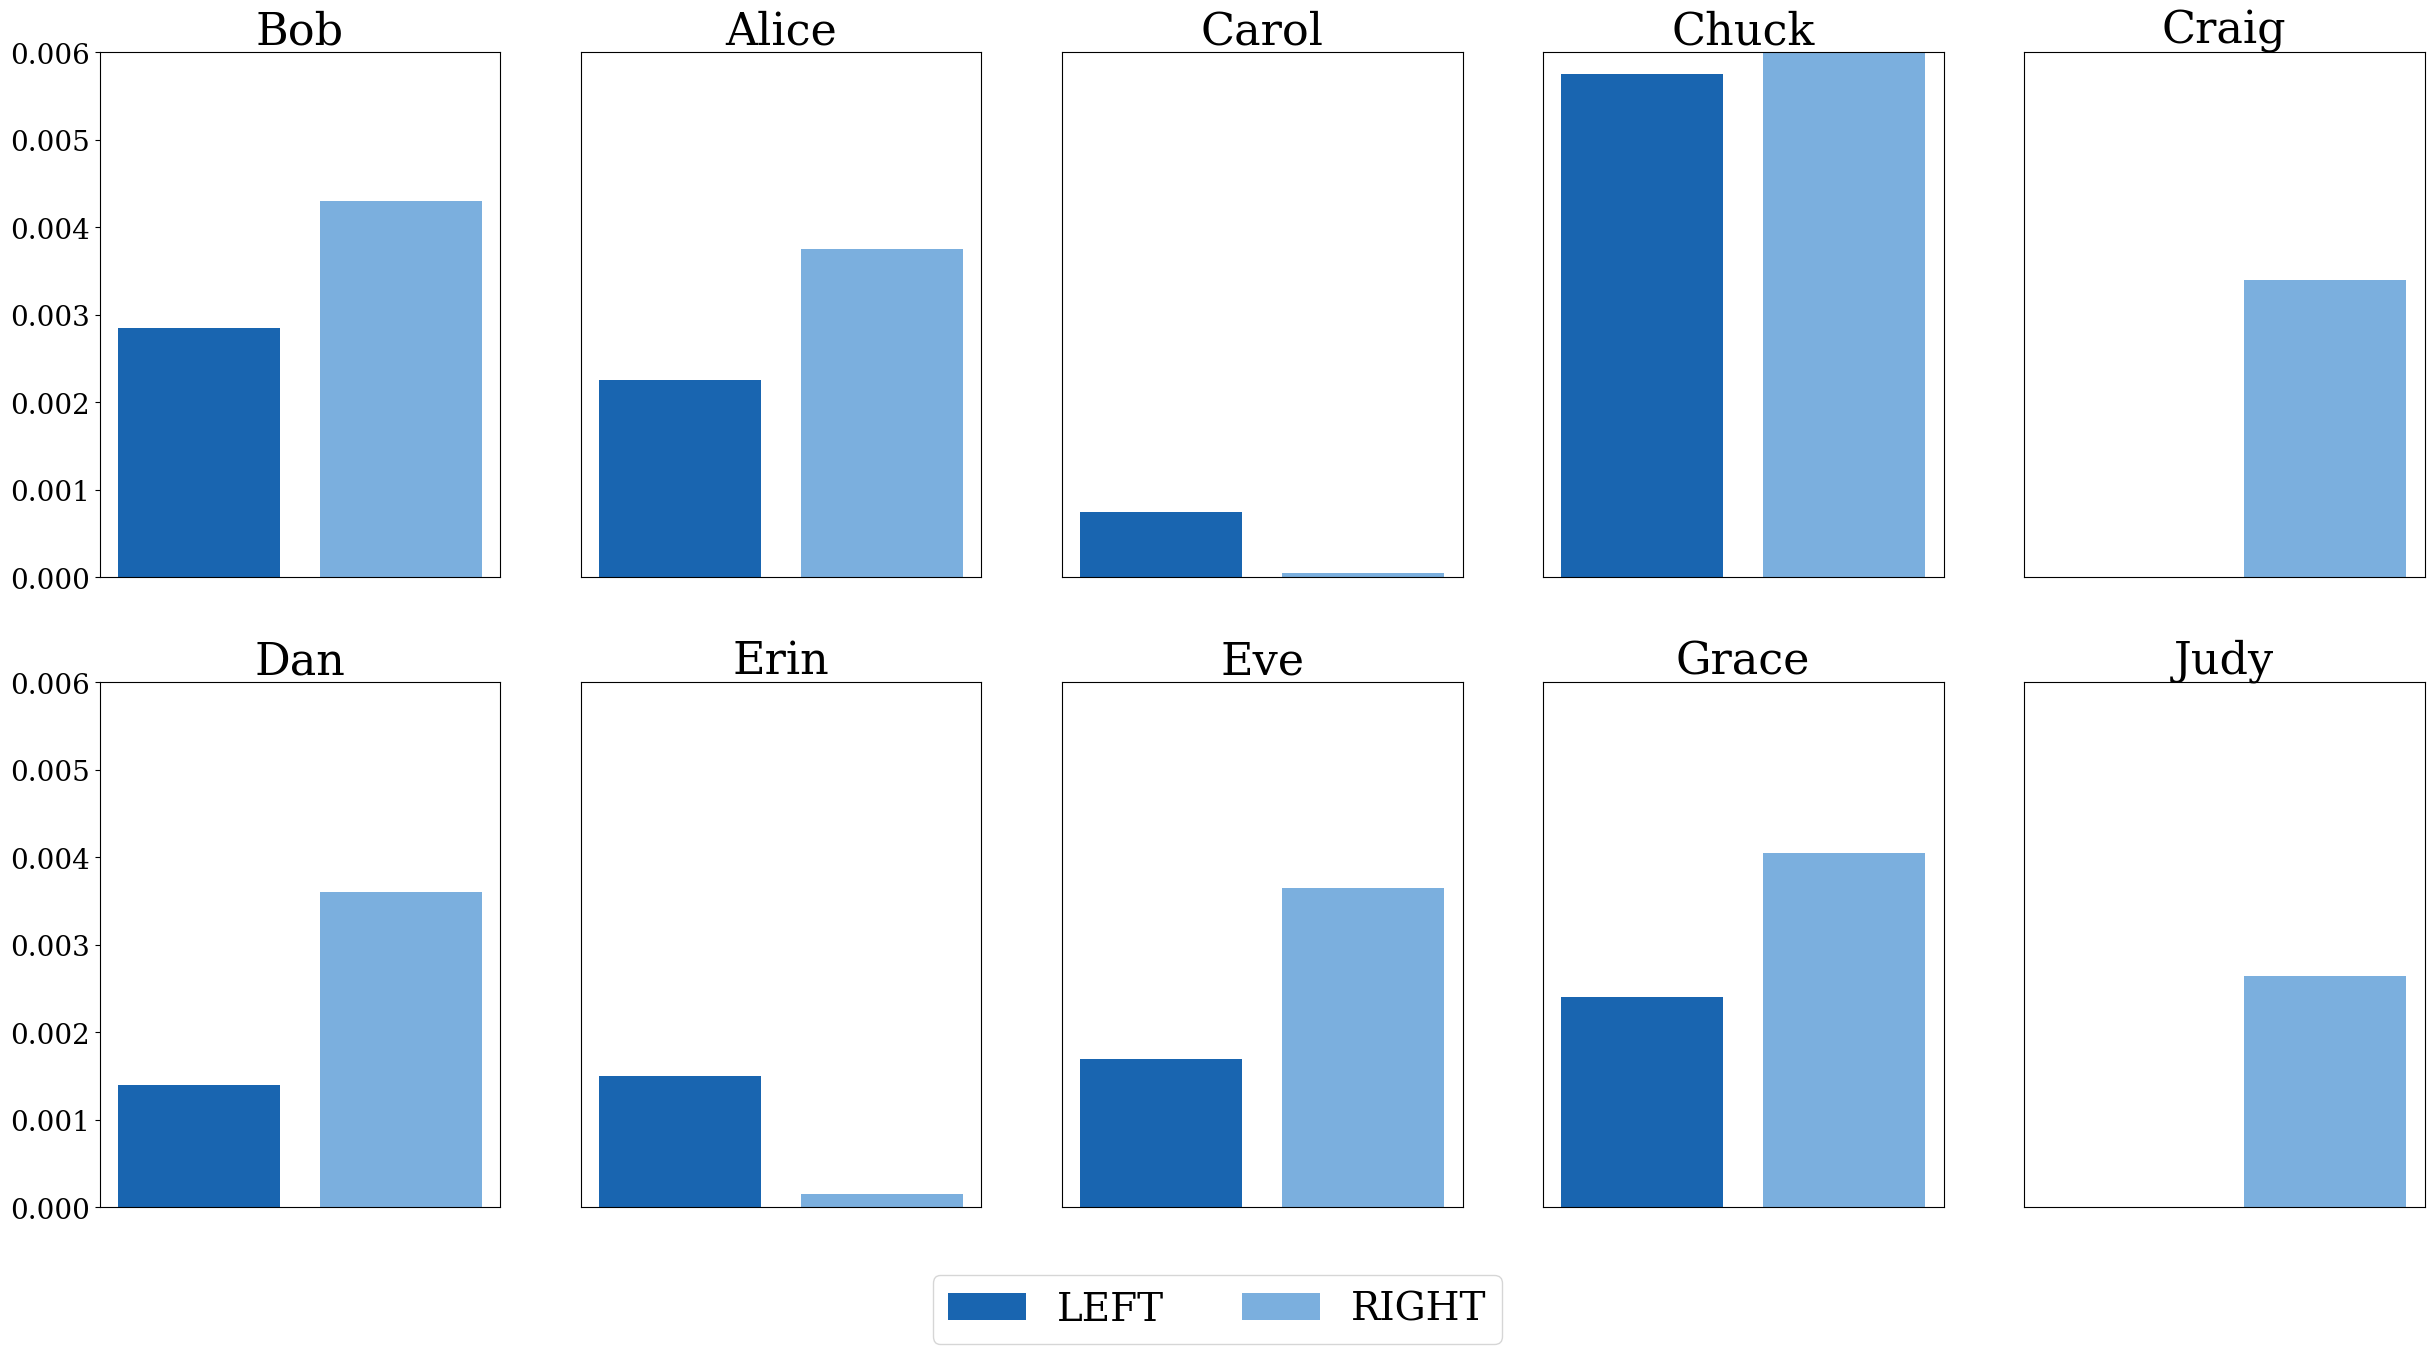

In [99]:
evaluations = pickle.load(open(base_dir + 'evaluations','rb'))
labels = ['NOP', 'LEFT', 'RIGHT']
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(30,15))
for i, agent in enumerate(agents):
    row = i // 5
    col = i % 5 
    evals = evaluations[agent][1]
    values = np.clip(evals,0,1)
    for j, v in enumerate(values):
        if j== 0:
            continue
        if i == 0:
            label = labels[j]
            
        else:
            label = None
        ax[row,col].bar(j, v,  color=colors[j], label=label)
    if  i % 5 == 0:
        ax[row,col].tick_params(labelsize=TICKS_FONT_SIZE)
    else:
        ax[row,col].set_yticks([])
    ax[row,col].set_title(agent,fontdict={'fontsize':TITLE_SIZE})
    ax[row,col].set_xticks([])
    ax[row,col].set_ylim((0,0.006))
log = fig.legend(loc='lower center', ncol = 3, fontsize=LEGEND_FONT_SIZE)
fig.savefig(base_dir + 'class_dist.pdf',format='pdf',bbox_extra_artists=(lgd,), bbox_inches='tight',)

# Plot the intra cluster accuracy (Figure 11)
## Prerequisite: Execute run_intra_cluster_accuracy.py to generate the data to plot

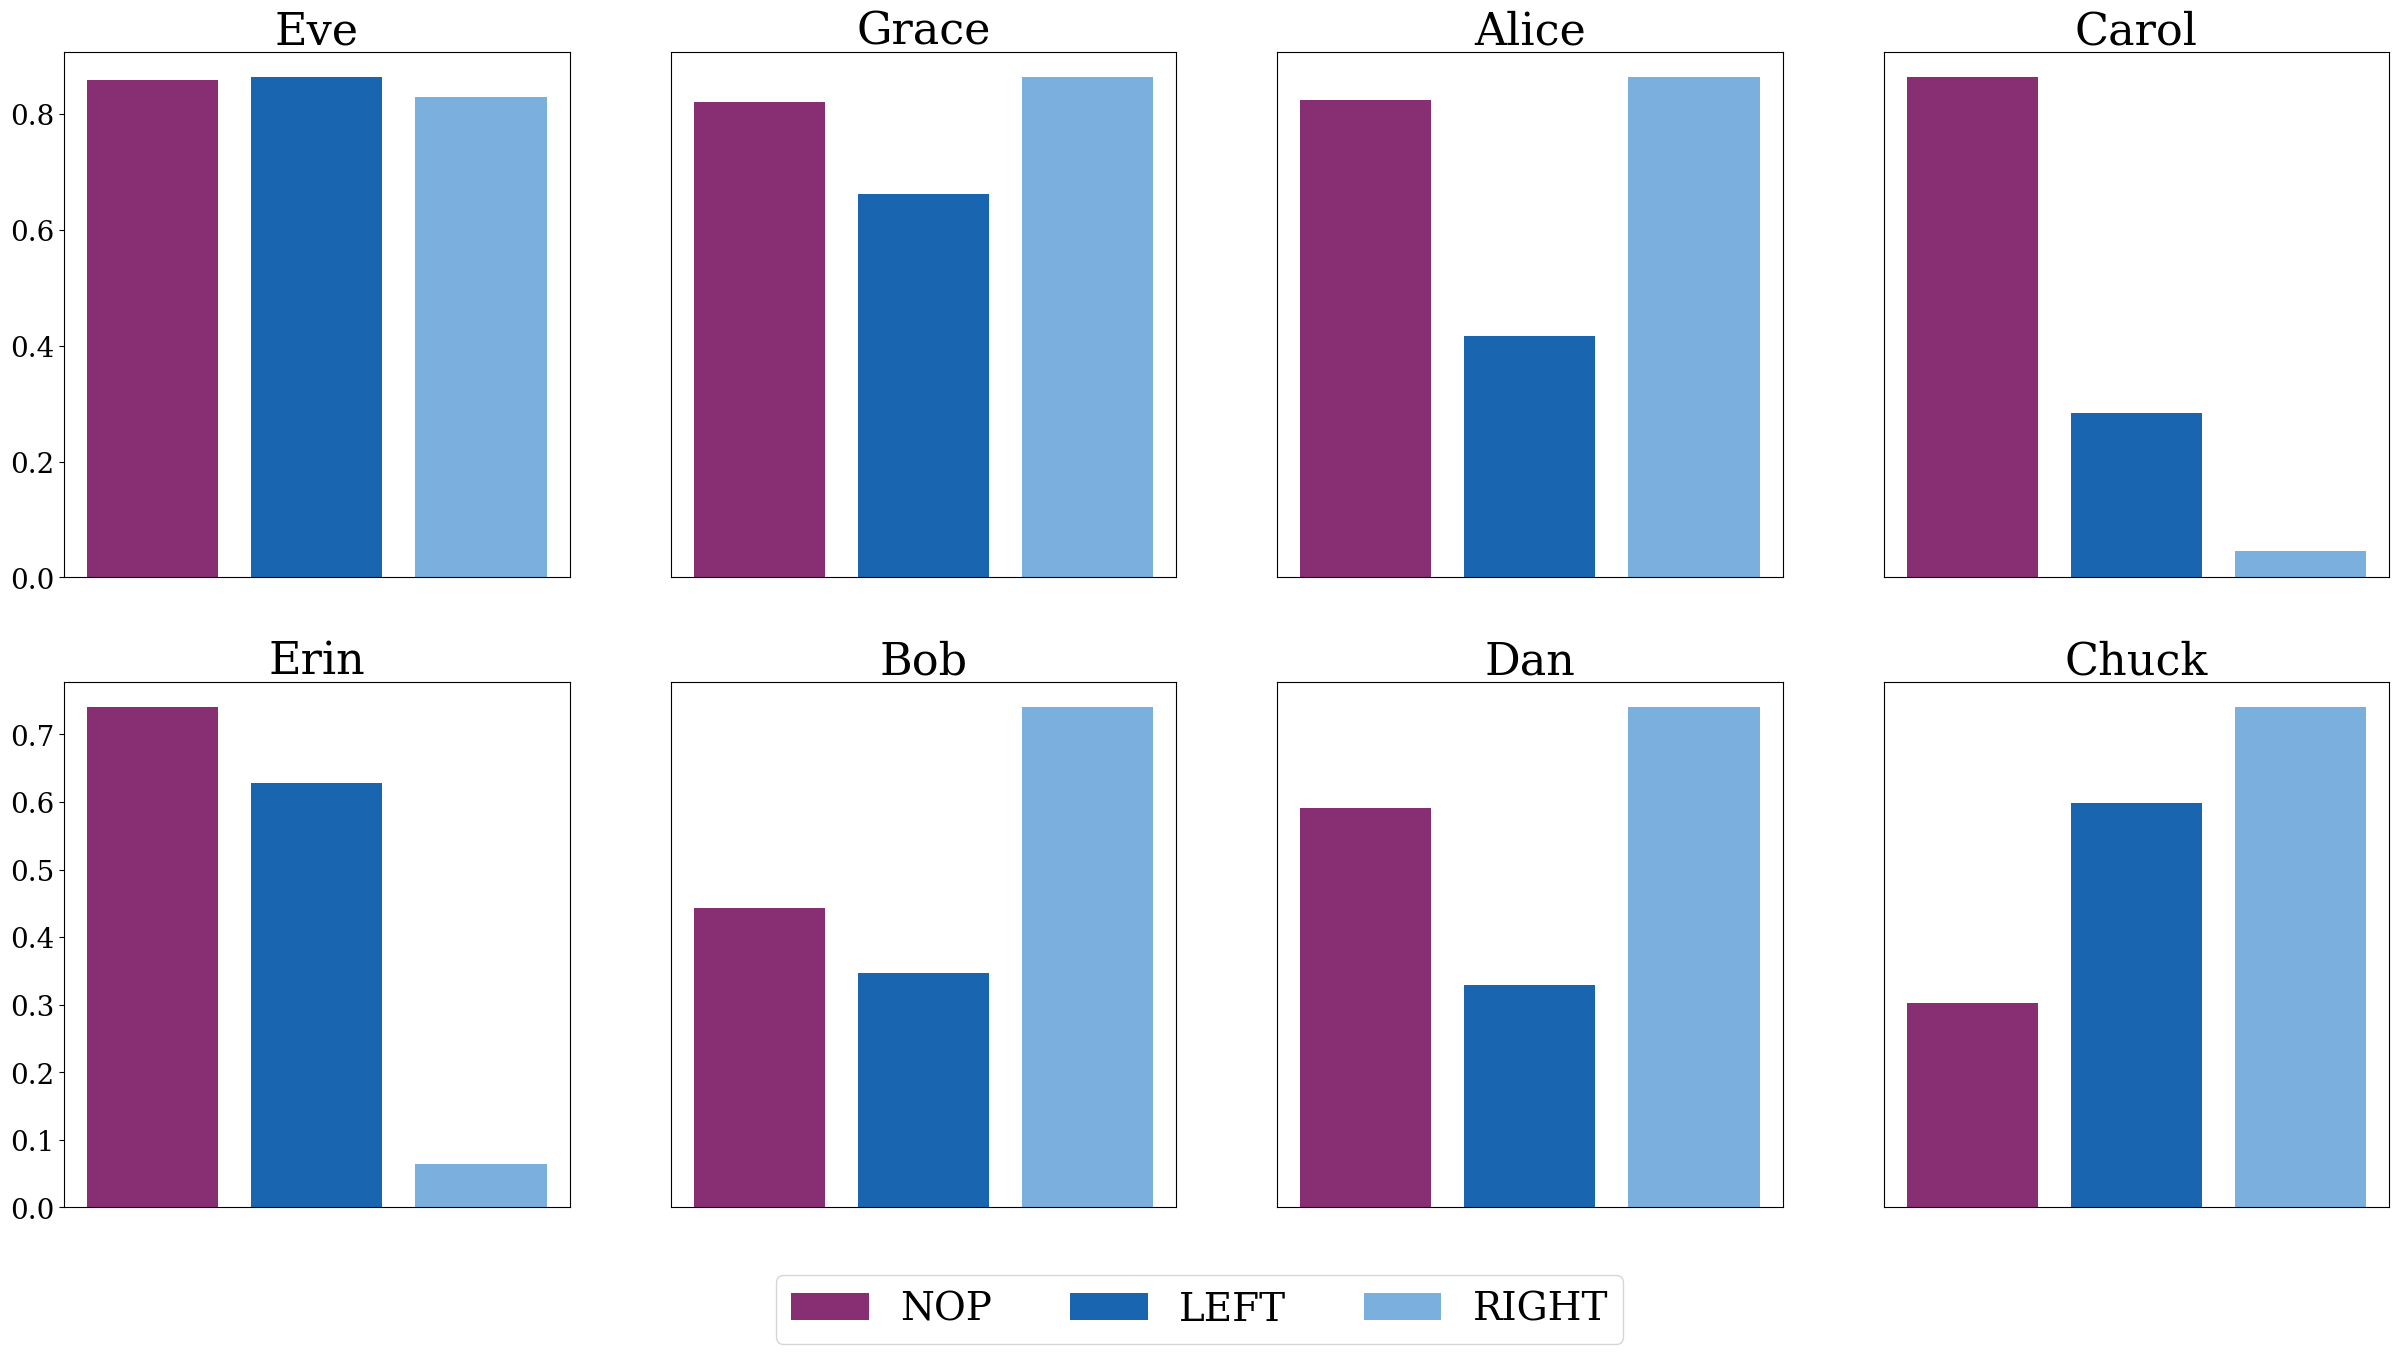

In [92]:
evaluations = pickle.load(open('../logs/highway/irl_evaluations','rb'))
cluster_agents = list(evaluations.keys())
labels = ['NOP', 'LEFT', 'RIGHT']
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(30,15))
for i, agent in enumerate(cluster_agents):
    
    row = i // 4
    col = i % 4
    evals = evaluations[agent][0]
    values = np.clip(evals,0,1)
    for j, v in enumerate(values):
        if i == 0:
            label = labels[j]
        else:
            label = None
        ax[row,col].bar(j, v,  color=colors[j], label=label)
    if  i % 4 == 0:
        ax[row,col].tick_params(labelsize=TICKS_FONT_SIZE)
    else:
        ax[row,col].set_yticks([])
    ax[row,col].set_title(agent,fontdict={'fontsize':TITLE_SIZE})
    ax[row,col].set_xticks([])
lgd = fig.legend(loc='lower center', ncol = 3, fontsize=LEGEND_FONT_SIZE)
fig.savefig(base_dir + 'mixed_evals.pdf',format='pdf',bbox_extra_artists=(lgd,), bbox_inches='tight',)

# Plot the policy and cluster return under the cluster reward functions (Figure 13 and 12)
## Prerequisite: Execute evaluate_trained_returns.py to generate the data to plot

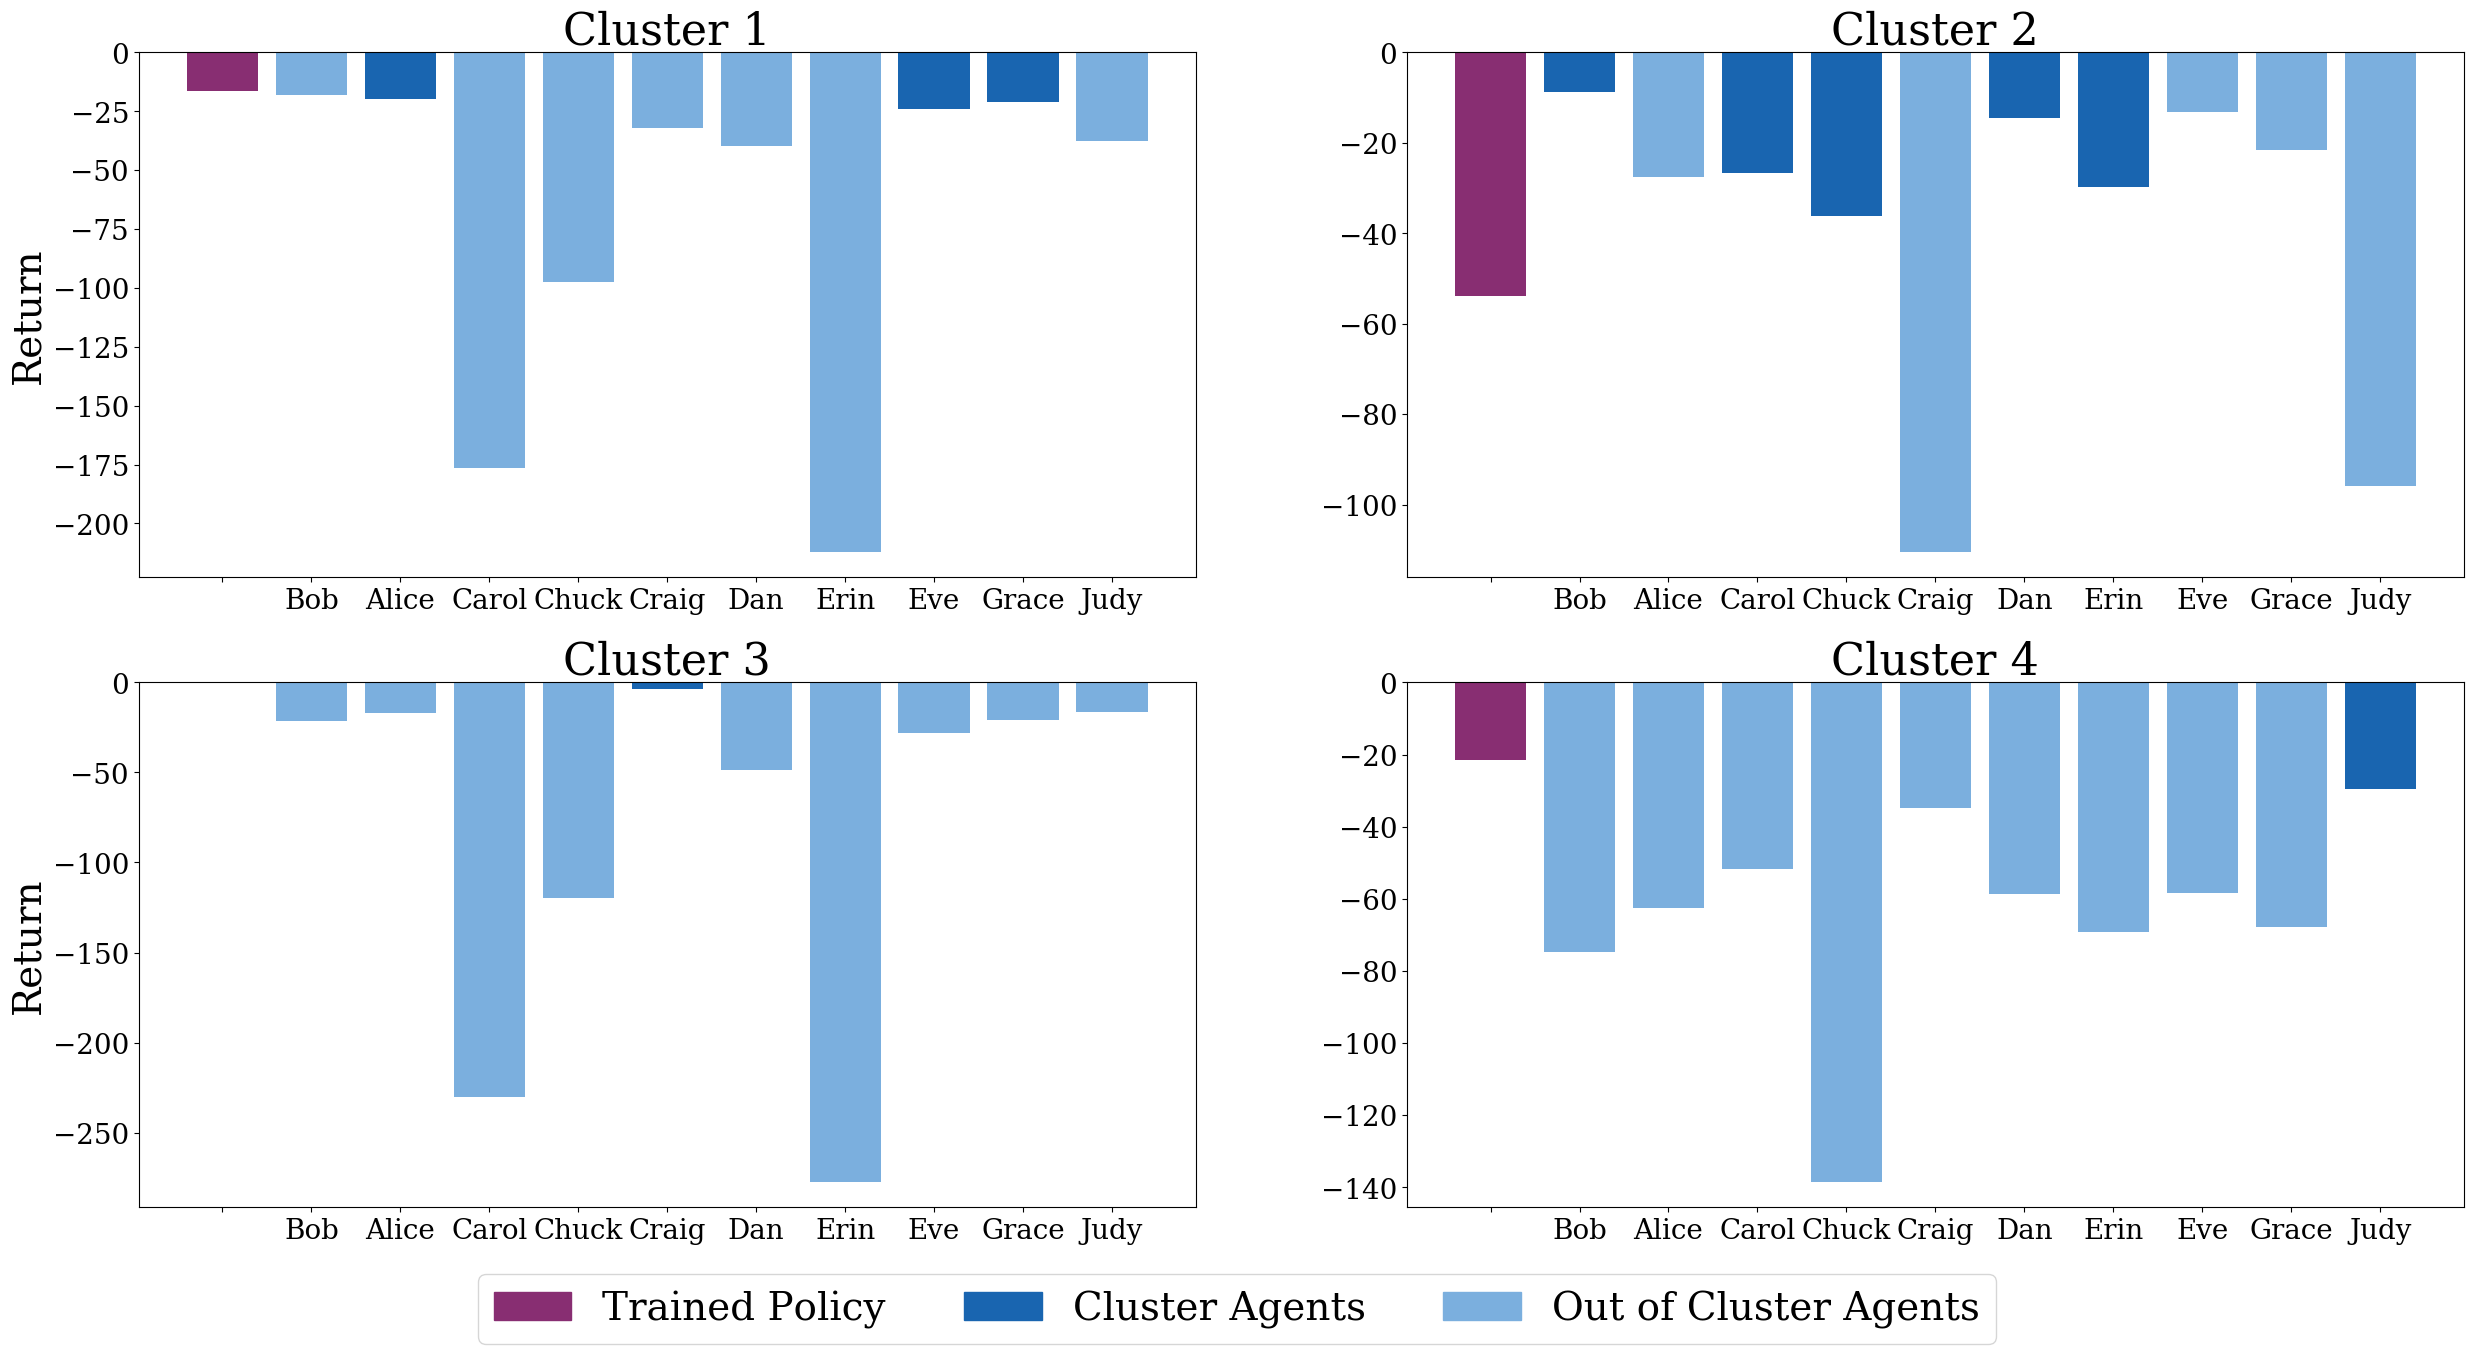

In [93]:

irl_clustering = [['Eve', 'Grace', 'Alice'],
                  ['Carol', 'Erin', 'Bob', 'Dan', 'Chuck'],
                  ['Craig'],
                  ['Judy']]
returns = np.zeros((len(irl_clustering), len(agents) + 1))
evaluations = pickle.load(open(base_dir + 'irl_returns','rb'))

labels = ['NOP', 'LEFT', 'RIGHT']

fig, ax = plt.subplots(nrows=2, ncols=len(irl_clustering) // 2,figsize=(30,15))
for i, data in enumerate(evaluations):
    col = i // 2
    row = i % 2
    cluster_returns, other_returns, trained_pol_return = data
    returns[i, 0] = trained_pol_return
    ax[col, row].bar(0, trained_pol_return,  color=colors[0], label='trained-policy')
    for j, agent in enumerate(irl_clustering[i]):
        agent_index = agents.tolist().index(agent)
        returns[i, agent_index + 1] = cluster_returns[j]
        
    agent_count = 0
    for j, agent in enumerate(agents):
        if agent not in irl_clustering[i]:
            agent_index = agents.tolist().index(agent)
            returns[i, agent_index + 1] = other_returns[agent_count]
            agent_count += 1
    for j, agent in enumerate(agents):
        color = colors[1] if agent in irl_clustering[i] else colors[2]
        ax[col, row].bar(j + 1, returns[i,j+1],  color=color, label=agent)
    ax[col, row].tick_params(labelsize=TICKS_FONT_SIZE)
    ax[col, row].set_title('Cluster ' + str(i + 1),fontdict={'fontsize':TITLE_SIZE})
    ax[col, row].set_xticklabels([''] + [agent for agent in agents])
    ax[col, row].set_xticks([0] + [i + 1  for i in range(len(agents))])
    if row == 0:
        ax[col, row].set_ylabel('Return',fontdict={'fontsize':AXIS_FONT_SIZE})
trained_patch = mpatches.Patch(color=colors[0], label='Trained Policy')
own_patch = mpatches.Patch(color=colors[1], label='Cluster Agents')
other_patch = mpatches.Patch(color=colors[2], label='Out of Cluster Agents')
lgd = fig.legend(loc='lower center', ncol = 3, fontsize=LEGEND_FONT_SIZE,
                 handles=[trained_patch, own_patch, other_patch] )
fig.savefig(base_dir + 'trained/returns.pdf',format='pdf',bbox_extra_artists=(lgd,), bbox_inches='tight',)

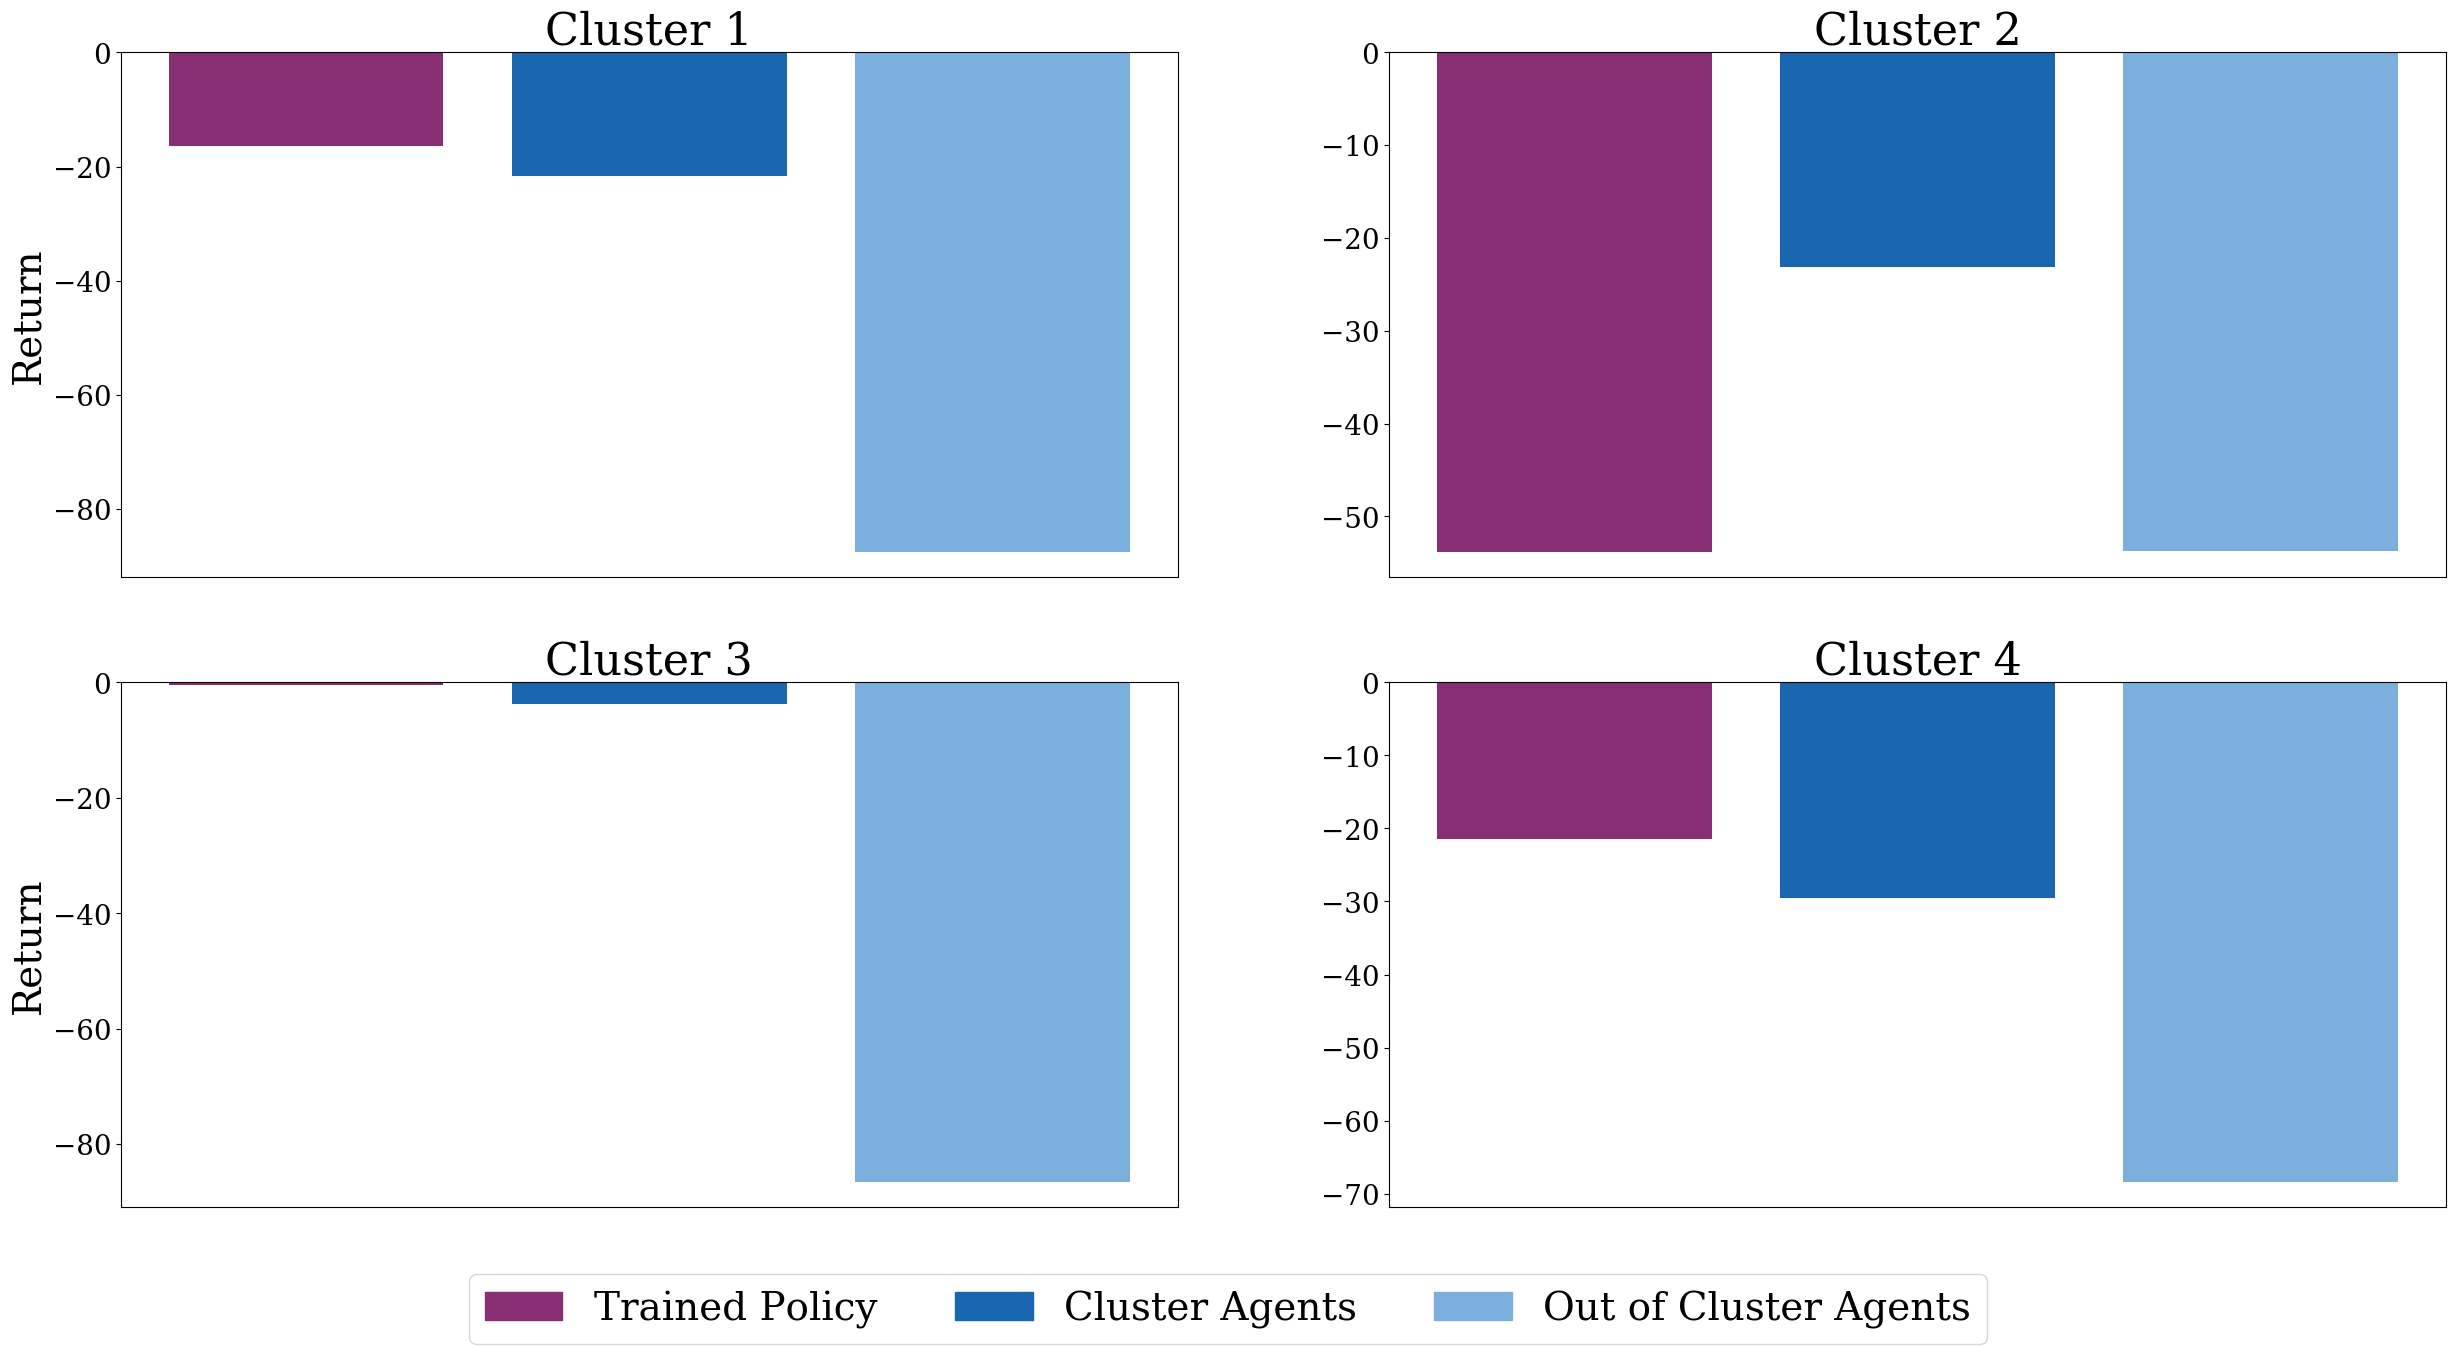

In [94]:
returns = np.zeros((len(irl_clustering), len(agents) + 1))
evaluations = pickle.load(open(base_dir + 'irl_returns','rb'))

labels = ['NOP', 'LEFT', 'RIGHT']
fig, ax = plt.subplots(nrows=2, ncols=len(irl_clustering) // 2,figsize=(30,15))
for i, data in enumerate(evaluations):
    col = i // 2
    row = i % 2
    own_cluster_return = other_cluster_return = 0
    cluster_returns, other_returns, trained_pol_return = data
    returns[i, 0] = trained_pol_return
    ax[col, row].bar(0, trained_pol_return,  color=colors[0], label='trained-policy')
    for j, agent in enumerate(irl_clustering[i]):
        agent_index = agents.tolist().index(agent)
        returns[i, agent_index + 1] = cluster_returns[j]
        own_cluster_return += cluster_returns[j]
    own_cluster_return /= len(irl_clustering[i])
    agent_count = 0
    for j, agent in enumerate(agents):
        if agent not in irl_clustering[i]:
            agent_index = agents.tolist().index(agent)
            returns[i, agent_index + 1] = other_returns[agent_count]
            other_cluster_return += other_returns[agent_count]
            agent_count += 1
    other_cluster_return /= agent_count
    ax[col, row].bar(1, own_cluster_return,  color=colors[1])
    ax[col, row].bar(2, other_cluster_return,  color=colors[2])
    ax[col, row].tick_params(labelsize=TICKS_FONT_SIZE)
    ax[col, row].set_title('Cluster ' + str(i + 1),fontdict={'fontsize':TITLE_SIZE})
    ax[col, row].set_xticks([])
    if row == 0:
        ax[col, row].set_ylabel('Return',fontdict={'fontsize':AXIS_FONT_SIZE})
trained_patch = mpatches.Patch(color=colors[0], label='Trained Policy')
own_patch = mpatches.Patch(color=colors[1], label='Cluster Agents')
other_patch = mpatches.Patch(color=colors[2], label='Out of Cluster Agents')
lgd = fig.legend(loc='lower center', ncol = 3, fontsize=LEGEND_FONT_SIZE,
                 handles=[trained_patch, own_patch, other_patch] )
fig.savefig(base_dir + 'trained/returns_aggregated.pdf',format='pdf',bbox_extra_artists=(lgd,), bbox_inches='tight',)